# Lifecycle Engagement & Participation Gaps

## Objective

This notebook examines **lifecycle engagement patterns** within the UIDAI system using district-level aggregate data for 2025.

While enrolment represents entry into the UIDAI ecosystem, biometric and demographic updates reflect **ongoing lifecycle interaction**.  
Disparities between these signals highlight districts where participation and follow-through may be uneven.

## Key Framing Principles

- This analysis uses **single-year, aggregate data** and does **not track individual cohorts**.
- All ratios are interpreted as **system-level engagement signals**, not lifecycle completion rates.
- Low engagement indicates potential **access, awareness, or infrastructure gaps**, not individual non-compliance.

Operational stress is analyzed separately in Notebook 3.  
This notebook focuses on **participation and follow-through signals across lifecycle stages**.

## Step 1: Load Cleaned District-Level Datasets

We begin by loading the cleaned and standardized district-level datasets produced in Notebook 1.

These datasets serve as the single source of truth for all stress calculations.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
enrol = pd.read_csv("../data/processed/enrolment_clean.csv", parse_dates=["date"])
demo  = pd.read_csv("../data/processed/demographic_updates_clean.csv", parse_dates=["date"])
bio   = pd.read_csv("../data/processed/biometric_updates_clean.csv", parse_dates=["date"])

## Step 2: Construct District-Level Lifecycle Master Table

All activity is aggregated across time to the **district level** to capture cumulative lifecycle interaction during the year.

### Aggregate enrolments

In [33]:
enrol_agg = enrol.groupby(["state", "district"], as_index=False)[
    ["age_0_5", "age_5_17", "age_18_greater"]
].sum()

### Aggregate biometric updates

In [34]:
bio_agg = bio.groupby(["state", "district"], as_index=False)[
    ["bio_age_5_17", "bio_age_17_plus"]
].sum()

### Aggregate demographic updates

In [35]:
demo_agg = demo.groupby(["state", "district"], as_index=False)[
    ["demo_age_17_plus"]
].sum()

### Merge into master table

In [36]:
master = (
    enrol_agg.merge(bio_agg, on=["state", "district"], how="inner")
             .merge(demo_agg, on=["state", "district"], how="inner")
)

master = master[
    (master["age_5_17"] > 0) |
    (master["age_18_greater"] > 0)
]

master.head()

,state,district,age_0_5,age_5_17,age_18_greater,bio_age_5_17,bio_age_17_plus,demo_age_17_plus
0,Andaman & Nicobar Islands,Andamans,13,2,0,231,1250,405
3,Andaman and Nicobar Islands,Nicobar,33,5,0,824,691,564
4,Andaman and Nicobar Islands,North And Middle Andaman,48,1,0,2830,2310,1358
5,Andaman and Nicobar Islands,South Andaman,52,4,0,5193,2979,1647
6,Andhra Pradesh,Adilabad,473,105,0,8505,28378,14236


## Step 3: Lifecycle Engagement Ratios

Lifecycle engagement is measured **relative to eligible enrolled populations**, not enrolment inflows.

### Child Biometric Engagement (ages 5-17)

In [37]:
master["child_bio_engagement"] = (
    master["bio_age_5_17"] / master["age_5_17"]
).replace([np.inf, -np.inf], np.nan)

### Adult Biometric Engagement (age 17+)

In [38]:
master["adult_bio_engagement"] = (
    master["bio_age_17_plus"] / master["age_18_greater"]
).replace([np.inf, -np.inf], np.nan)

### Adult Demographic Engagement (age 17+)

In [39]:
master["adult_demo_engagement"] = (
    master["demo_age_17_plus"] / master["age_18_greater"]
).replace([np.inf, -np.inf], np.nan)

### Distribution of Lifecycle Engagement Ratios

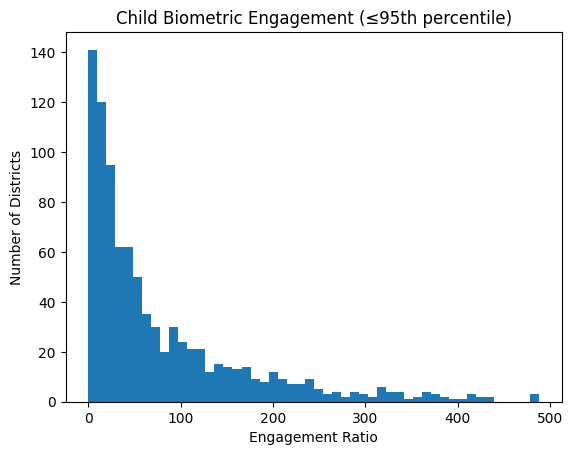

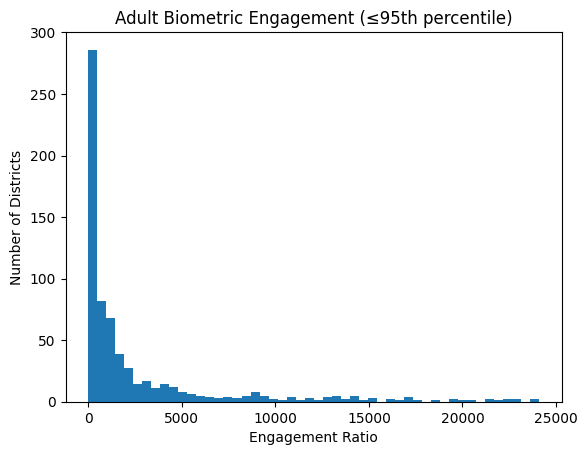

In [40]:
cap = master["child_bio_engagement"].quantile(0.95)

plt.figure()
plt.hist(
    master.loc[
        master["child_bio_engagement"] <= cap,
        "child_bio_engagement"
    ],
    bins=50
)
plt.title("Child Biometric Engagement (≤95th percentile)")
plt.xlabel("Engagement Ratio")
plt.ylabel("Number of Districts")
plt.show()

cap = master["adult_bio_engagement"].quantile(0.95)

plt.figure()
plt.hist(
    master.loc[
        master["adult_bio_engagement"] <= cap,
        "adult_bio_engagement"
    ],
    bins=50
)
plt.title("Adult Biometric Engagement (≤95th percentile)")
plt.xlabel("Engagement Ratio")
plt.ylabel("Number of Districts")
plt.show()

### Interpretation

Lifecycle engagement distributions are **highly right-skewed**.

- Most districts cluster at relatively low engagement levels.
- A small number of districts exhibit exceptionally high interaction intensity, reflecting uneven system interaction rather than uniform behavior.

Subsequent analysis therefore focuses on **districts at the low end of the engagement distribution**, where weaker lifecycle interaction may signal access or follow-through gaps.

## Step 4: Contextual Normalization Using Enrolment Peer Groups

To account for district scale differences, lifecycle engagement is compared across **peer enrolment groups**.

In [41]:
master["total_enrolments"] = (
    master["age_0_5"] +
    master["age_5_17"] +
    master["age_18_greater"]
)

master["enrolment_bin"] = pd.qcut(
    master["total_enrolments"],
    q=3,
    labels=["Low Enrolment", "Medium Enrolment", "High Enrolment"]
)

In [42]:
for col in [
    "child_bio_engagement",
    "adult_bio_engagement",
    "adult_demo_engagement"
]:
    master[f"{col}_expected"] = (
        master.groupby("enrolment_bin", observed=False)[col]
              .transform("median")
    )

## Step 5: Identifying Lifecycle Engagement Gaps

In [43]:
# Percentile thresholds
child_p10 = master["child_bio_engagement"].quantile(0.10)
adult_bio_p10 = master["adult_bio_engagement"].quantile(0.10)
adult_demo_p10 = master["adult_demo_engagement"].quantile(0.10)

master["low_child_engagement"] = master["child_bio_engagement"] <= child_p10
master["low_adult_bio_engagement"] = master["adult_bio_engagement"] <= adult_bio_p10
master["low_adult_demo_engagement"] = master["adult_demo_engagement"] <= adult_demo_p10

In [44]:
master["lifecycle_gap_score"] = (
    master["low_child_engagement"].astype(int) +
    master["low_adult_bio_engagement"].astype(int) +
    master["low_adult_demo_engagement"].astype(int)
)

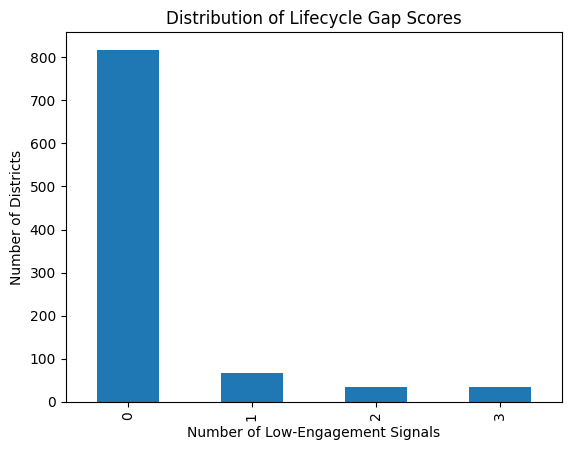

In [45]:
plt.figure()
master["lifecycle_gap_score"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribution of Lifecycle Gap Scores")
plt.xlabel("Number of Low-Engagement Signals")
plt.ylabel("Number of Districts")
plt.show()

## Step 6: Key Lifecycle Gap Districts

Districts exhibiting **multiple low-engagement signals** represent areas with the weakest lifecycle follow-through.

In [46]:
gap_districts = master.loc[
    master["lifecycle_gap_score"] >= 2
].sort_values(
    ["lifecycle_gap_score", "adult_bio_engagement"],
    ascending=[False, True]
).reset_index(drop=True)

gap_districts[[
    "state",
    "district",
    "enrolment_bin",
    "child_bio_engagement",
    "adult_bio_engagement",
    "adult_demo_engagement",
    "lifecycle_gap_score"
]].head(15)

,state,district,enrolment_bin,child_bio_engagement,adult_bio_engagement,adult_demo_engagement,lifecycle_gap_score
0,Karnataka,Bengaluru Rural,High Enrolment,0.005487,0.003221,0.062802,3
1,Mizoram,Khawzawl,Low Enrolment,0.000000,0.250000,5.000000,3
2,Assam,Dima Hasao,Low Enrolment,0.057471,0.291667,5.708333,3
3,Bihar,Pashchim Champaran,High Enrolment,0.002259,0.335155,0.890710,3
4,Meghalaya,East Jaintia Hills,High Enrolment,0.639238,0.376206,1.322830,3
5,Tamil Nadu,Kanchipuram,Low Enrolment,0.000000,0.454545,0.454545,3
6,Meghalaya,Ri Bhoi,High Enrolment,0.439728,0.470381,1.837094,3
7,Meghalaya,West Jaintia Hills,High Enrolment,0.646658,0.483724,1.568604,3
8,Gujarat,Banas Kantha,High Enrolment,0.005100,0.492586,0.299835,3
9,Meghalaya,South Garo Hills,High Enrolment,0.232076,0.497592,2.382825,3


### Interpretation

The districts listed above exhibit **weak engagement across multiple lifecycle stages**, indicating systemic follow-through challenges rather than isolated issues.

Notably:
- Gaps are observed across different enrolment scales.
- Several districts show both child and adult engagement deficits.
- These patterns suggest localized access, awareness, or infrastructure constraints.

These districts represent **priority candidates for targeted outreach and service strengthening**.

In [47]:
gap_share = len(gap_districts) / len(master)

print(
    f"Districts with multi-signal lifecycle gaps: {gap_share:.1%} of all districts"
)

Districts with multi-signal lifecycle gaps: 7.2% of all districts


## Step 7: Lifecycle Gap Typology

Lifecycle gaps manifest in distinct structural patterns that can inform targeted interventions.

## Lifecycle Engagement Typologies

Based on enrolment scale and lifecycle engagement signals, districts are classified into the following typologies:

- **High enrolment, weak engagement**  
  Districts with large enrolled populations but weak lifecycle follow-through, indicating system reach without sustained interaction.

- **Low enrolment, weak engagement**  
  Districts facing structural access constraints, where both entry and follow-through are limited.

- **Child engagement strong, adult drop-off**  
  Districts where child revalidation is relatively strong but adult lifecycle engagement weakens, suggesting transition-stage barriers.

- **Healthy lifecycle engagement**  
  Districts exhibiting consistent interaction across lifecycle stages.

- **Mixed or transitional pattern**  
  Districts not cleanly fitting into a single category.

### Defining Typology Flags

In [48]:
# Convenience flags
high_enrolment = master["enrolment_bin"] == "High Enrolment"
low_enrolment  = master["enrolment_bin"] == "Low Enrolment"

weak_child  = master["low_child_engagement"]
weak_adult  = master["low_adult_bio_engagement"]
weak_demo   = master["low_adult_demo_engagement"]

strong_child = ~weak_child
strong_adult = ~weak_adult

### Assigning Lifecycle Typologies

In [49]:
def assign_typology(row):

    # High enrolment, weak engagement
    if row["enrolment_bin"] == "High Enrolment" and (
        row["low_child_engagement"] or row["low_adult_bio_engagement"]
    ):
        return "High enrolment, weak engagement"

    # Low enrolment, weak engagement
    if row["enrolment_bin"] == "Low Enrolment" and (
        row["low_child_engagement"] or row["low_adult_bio_engagement"]
    ):
        return "Low enrolment, weak engagement"

    # Adult drop-off
    if (not row["low_child_engagement"]) and row["low_adult_bio_engagement"]:
        return "Child engagement strong, adult drop-off"

    # Healthy lifecycle
    if row["lifecycle_gap_score"] == 0:
        return "Healthy lifecycle engagement"

    # Everything else
    return "Mixed or transitional pattern"


master["lifecycle_typology"] = master.apply(assign_typology, axis=1)

## Step 8: Using the typologies

### Typology Distribution

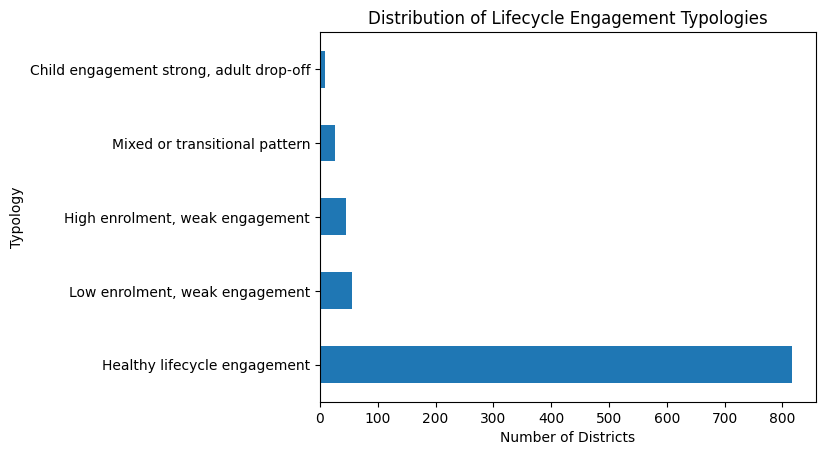

In [50]:
plt.figure()
master["lifecycle_typology"].value_counts().plot(kind="barh")
plt.title("Distribution of Lifecycle Engagement Typologies")
plt.xlabel("Number of Districts")
plt.ylabel("Typology")
plt.show()

### Top Districts by Typology

In [51]:
typology_tables = (
    master.loc[master["lifecycle_gap_score"] >= 1]
          .sort_values("lifecycle_gap_score", ascending=False)
)

typology_tables[[
    "state",
    "district",
    "enrolment_bin",
    "lifecycle_typology",
    "child_bio_engagement",
    "adult_bio_engagement",
    "adult_demo_engagement",
    "lifecycle_gap_score"
]].head(20)

,state,district,enrolment_bin,lifecycle_typology,child_bio_engagement,adult_bio_engagement,adult_demo_engagement,lifecycle_gap_score
61,Arunachal Pradesh,Longding,Medium Enrolment,Mixed or transitional pattern,2.332707,23.270270,21.594595,3
111,Assam,West Karbi Anglong,Medium Enrolment,Mixed or transitional pattern,0.858903,3.353659,1.804878,3
109,Assam,Tinsukia,High Enrolment,"High enrolment, weak engagement",5.282390,5.257761,16.167451,3
89,Assam,Golaghat,High Enrolment,"High enrolment, weak engagement",2.678336,3.450314,10.123899,3
95,Assam,Karbi Anglong,High Enrolment,"High enrolment, weak engagement",5.945580,11.982827,18.033025,3
96,Assam,Karimganj,High Enrolment,"High enrolment, weak engagement",5.369288,12.913043,31.951304,3
87,Assam,Dima Hasao,Low Enrolment,"Low enrolment, weak engagement",0.057471,0.291667,5.708333,3
721,Rajasthan,Jalore,Low Enrolment,"Low enrolment, weak engagement",0.005495,0.769231,33.538462,3
756,Tamil Nadu,Kanchipuram,Low Enrolment,"Low enrolment, weak engagement",0.000000,0.454545,0.454545,3
577,Nagaland,Chumukedima,Low Enrolment,"Low enrolment, weak engagement",2.888889,10.243243,25.000000,3


In [52]:
pd.crosstab(
    master["lifecycle_typology"],
    master["enrolment_bin"]
)

enrolment_bin,Low Enrolment,Medium Enrolment,High Enrolment
lifecycle_typology,,,
"Child engagement strong, adult drop-off",0,8,0
Healthy lifecycle engagement,260,289,268
"High enrolment, weak engagement",0,0,45
"Low enrolment, weak engagement",56,0,0
Mixed or transitional pattern,1,20,5


## Key Observations

Lifecycle engagement gaps are **highly concentrated and structurally patterned**, rather than diffuse across the system.

- Only **7.2% of districts exhibit multi-signal lifecycle gaps**, confirming that weak lifecycle interaction is a localized phenomenon rather than a system-wide issue.
- Districts classified as **“High enrolment, weak engagement” occur exclusively among high-enrolment districts**, indicating that follow-through challenges are not driven by lack of system reach, but by sustained interaction barriers.
- Conversely, **“Low enrolment, weak engagement” districts are confined to low-enrolment areas**, highlighting regions where both access and lifecycle continuity remain constrained.
- **Adult drop-off patterns appear only in medium-enrolment districts**, suggesting that lifecycle transition challenges emerge most visibly in districts with moderate scale rather than at the extremes.
- The majority of districts across all enrolment groups fall under **“Healthy lifecycle engagement”**, reinforcing that UIDAI’s lifecycle interaction mechanisms function effectively in most regions.

Taken together, these patterns indicate that lifecycle gaps are **not random anomalies**, but reflect **distinct structural contexts** that warrant differentiated, targeted interventions rather than uniform policy responses.

## Exporting Outputs for Dashboard

In [53]:
output_dir = "../outputs/notebook_4_lifecycle"

# District-level lifecycle metrics (PRIMARY EXPORT)
district_lifecycle_metrics = master[[
    "state",
    "district",
    "enrolment_bin",
    "lifecycle_typology",
    "child_bio_engagement",
    "adult_bio_engagement",
    "adult_demo_engagement",
    "lifecycle_gap_score"
]]

district_lifecycle_metrics.to_csv(
    f"{output_dir}/district_lifecycle_metrics.csv",
    index=False
)

# Lifecycle gap districts (multi-signal gaps)
lifecycle_gap_districts = master.loc[
    master["lifecycle_gap_score"] >= 2
].sort_values(
    ["lifecycle_gap_score", "adult_bio_engagement"],
    ascending=[False, True]
)

lifecycle_gap_districts.to_csv(
    f"{output_dir}/lifecycle_gap_districts.csv",
    index=False
)

# Lifecycle summary KPIs
lifecycle_summary_metrics = pd.DataFrame({
    "metric": [
        "multi_signal_gap_district_share"
    ],
    "value": [
        (master["lifecycle_gap_score"] >= 2).mean()
    ]
})

lifecycle_summary_metrics.to_csv(
    f"{output_dir}/lifecycle_summary_metrics.csv",
    index=False
)

# Lifecycle typology counts
lifecycle_typology_counts = (
    master["lifecycle_typology"]
    .value_counts()
    .reset_index()
    .rename(columns={
        "index": "lifecycle_typology",
        "lifecycle_typology": "district_count"
    })
)

lifecycle_typology_counts.to_csv(
    f"{output_dir}/lifecycle_typology_counts.csv",
    index=False
)

print("Notebook 4 exports completed successfully.")

Notebook 4 exports completed successfully.
